# Slow code 

In [65]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 18 10:19:34 2021

@author: Valen
"""
#Hello

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller

# imports other libs
import time
import numpy as np
#from math import fabs,sqrt
import os

# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'individual_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
                  enemies=[2],
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")

# default environment fitness is assumed for experiment

env.state_to_log() # checks environment state


####   Optimization for controller solution (best genotype-weights for phenotype-network): Ganetic Algorihm    ###

ini = time.time()  # sets time marker


# genetic algorithm params

run_mode = 'train' # train or test

# number of weights for multilayer with 10 hidden neurons
n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5
print("Number of weights: " + str(n_vars))


# runs simulation
def simulation(env,x):
    f,p,e,t = env.play(pcont=x)
    return f

# evaluation
def evaluate(x):
    return np.array(list(map(lambda y: simulation(env,y), x)))

# DEAP - own code starts here 
from deap import base, creator
import random
from deap import tools
#maximizing fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)
from array import array
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars
MIN_VALUE, MAX_VALUE = -1., 1.
MIN_STRAT, MAX_STRAT = -1., 1. 

toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)


#uniform = random.uniform(-1, 1)
toolbox.register("attribute", np.random.uniform, -1, 1)
#random.uniform(-1.,1.)
#toolbox.register("individual", tools.initRepeat, creator.Individual,
#                 toolbox.attribute, n= n_vars)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("population", tools.initRepeat, np.array([]), toolbox.individual)



toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb=0.1)
toolbox.register("parentselection", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
logbook = tools.Logbook()


pop_size = 20

#test

def main():
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    
    pop = toolbox.population(n=pop_size)
    CXPB, MUTPB, NGEN = 0.7, 0.2, 10

    # Evaluate the entire population
    #fitnesses = map(toolbox.evaluate, np.array(pop))
    #for ind, fit in zip(pop, fitnesses):
    #    ind.fitness.values = fit
    for i in range(len(pop)):
        fitness = toolbox.evaluate(np.array([pop[i]]))
        pop[i].fitness.values = fitness
        if fitness > best_fit:
            best_fit = fitness
            best_ind = pop[i]

    # show first random generation
    record = stats.compile(pop)
    print("Gen 0: ")
    print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        
        #like this
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        print(len(offspring)) 
        
        #or like this
# =============================================================================
#         for child1, child2 in zip(parents[::2], parents[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
# =============================================================================
                
        # mutation
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #for i in range(len(invalid_ind)):
        #    invalid_ind[i].fitness.values = toolbox.evaluate(np.array([invalid_ind[i]]))
        for i in range(len(offspring)):
            fitness = toolbox.evaluate(np.array([offspring[i]]))
            offspring[i].fitness.values = fitness
            if fitness > best_fit:
                best_fit = fitness
                best_ind = offspring[i]
                
        #fitnesses = map(toolbox.evaluate, np.array(offspring).reshape(1, len(offspring), n_vars))
        #for ind, fit in zip(offspring, fitnesses):
        #    ind.fitness.values = fit
        #    if max(fit) > best_fit:
        #        best_fit = max(fit)
        #        best_ind = pop[np.where(fit == max(fit))[0][0]]
            
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        print(len(pop))
        
        record = stats.compile(pop)
        print("Gen : " + str(g+1))
        print(record)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind



MESSAGE: Pygame initialized for simulation.

########## Simulation state - INI ###########

# solutions # : EMPTY 

# sensors # : 20

 ------  parameters ------  

# contact hurt (training agent) # : player

multiple mode: no

enemies list: 2

current enemy: 2

player mode: ai

enemy mode: static

level: 2

clock precision: low

inputs coded: no

random initialization: yes

expiration time: 3000

speed: fastest

load player: yes

load enemy: yes

sound: off

overture time: 100

logs: on

save logs: yes

########## Simulation state - END ###########
Number of weights: 265


# Fast Code

## Two point cross-over

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 18 10:19:34 2021

@author: Valen
"""
#Hello

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller

# imports other libs
import time
import numpy as np
#from math import fabs,sqrt
import os

from multiprocess import Pool
import psutil

num_cpus = psutil.cpu_count(logical=False)
pool = Pool(num_cpus)

# choose this for not using visuals and thus making experiments faster
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"


experiment_name = 'individual_demo'
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

n_hidden_neurons = 10

# initializes simulation in individual evolution mode, for single static enemy.
env = Environment(experiment_name=experiment_name,
              enemies=[2],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")

# default environment fitness is assumed for experiment

env.state_to_log() # checks environment state


####   Optimization for controller solution (best genotype-weights for phenotype-network): Ganetic Algorihm    ###

ini = time.time()  # sets time marker


# genetic algorithm params

run_mode = 'train' # train or test

# number of weights for multilayer with 10 hidden neurons
n_vars = (env.get_num_sensors()+1)*n_hidden_neurons + (n_hidden_neurons+1)*5
print("Number of weights: " + str(n_vars))


# runs simulation
def simulation(x, player_controller = player_controller, Environment = Environment):
    #unconventional, but necessary to run code on multiple cores to speed up processing 
    n_hidden_neurons = 10
    experiment_name = 'individual_demo'
    env = Environment(experiment_name=experiment_name,
                  enemies=[6],
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")
    
    f,p,e,t = env.play(pcont=x)
    return f

# DEAP - own code starts here 
from deap import base, creator
import random
from deap import tools
#maximizing fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)
from array import array
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars
MIN_VALUE, MAX_VALUE = -1., 1.
MIN_STRAT, MAX_STRAT = -1., 1. 

toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)


#uniform = random.uniform(-1, 1)
toolbox.register("attribute", np.random.uniform, -1, 1)
#random.uniform(-1.,1.)
#toolbox.register("individual", tools.initRepeat, creator.Individual,
#                 toolbox.attribute, n= n_vars)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("population", tools.initRepeat, np.array([]), toolbox.individual)


# register tools 
#toolbox.register("mate", tools.cxESTwoPoint)
#toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb=0.1)
#toolbox.register("parentselection", tools.selTournament, tournsize=3)
toolbox.register("evaluate", simulation)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
logbook = tools.Logbook()


#test

def twopointcx(CXPB, offsprMUTPB, allelmutpb, tournsize):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    toolbox.register("mate", tools.cxESTwoPoint)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    #CXPB, MUTPB, NGEN = 0.7, 0.2, 10

    # Evaluate the entire population
    #fitnesses = map(toolbox.evaluate, np.array(pop))
    #for ind, fit in zip(pop, fitnesses):
    #    ind.fitness.values = fit
    #for i in range(len(pop)):
    #    fitness = toolbox.evaluate(np.array([pop[i]]))
    #    pop[i].fitness.values = fitness
    #    if fitness > best_fit:
    #        best_fit = fitness
    #        best_ind = pop[i]

    if __name__ == '__main__':
    #multiprocessing.set_start_method('fork')
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit:
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # show first random generation
    record = stats.compile(pop)
    #print("Gen 0: ")
    #print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        
        #like this
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        #print(len(offspring)) 
        
        #or like this
# =============================================================================
#         for child1, child2 in zip(parents[::2], parents[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
# =============================================================================
                
        # mutation
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #for i in range(len(invalid_ind)):
        #    invalid_ind[i].fitness.values = toolbox.evaluate(np.array([invalid_ind[i]]))
        #for i in range(len(offspring)):
        #    fitness = toolbox.evaluate(np.array([offspring[i]]))
        #    offspring[i].fitness.values = fitness
        #    if fitness > best_fit:
        #        best_fit = fitness
        #        best_ind = offspring[i]
                
        #fitnesses = map(toolbox.evaluate, np.array(offspring).reshape(1, len(pop), n_vars))
        #for ind, fit in zip(pop, fitnesses):
        #    ind.fitness.values = fit
        #    if max(fit) > best_fit:
        #        best_fit = max(fit)
        #        best_ind = pop[np.where(fit == max(fit))[0][0]]
        
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        #print(len(pop))
        
        record = stats.compile(pop)
        #print("Gen : " + str(g+1))
        #print(record)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit



MESSAGE: Pygame initialized for simulation.

########## Simulation state - INI ###########

# solutions # : EMPTY 

# sensors # : 20

 ------  parameters ------  

# contact hurt (training agent) # : player

multiple mode: no

enemies list: 2

current enemy: 2

player mode: ai

enemy mode: static

level: 2

clock precision: low

inputs coded: no

random initialization: yes

expiration time: 3000

speed: fastest

load player: yes

load enemy: yes

sound: off

overture time: 100

logs: on

save logs: yes

########## Simulation state - END ###########
Number of weights: 265


## Blend Crossover 

In [20]:
def blendcx(CXPB, offsprMUTPB, allelmutpb, tournsize):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100

    toolbox.register("mate", tools.cxESBlend)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    #CXPB, MUTPB, NGEN = 0.7, 0.2, 10

    # Evaluate the entire population
    #fitnesses = map(toolbox.evaluate, np.array(pop))
    #for ind, fit in zip(pop, fitnesses):
    #    ind.fitness.values = fit
    #for i in range(len(pop)):
    #    fitness = toolbox.evaluate(np.array([pop[i]]))
    #    pop[i].fitness.values = fitness
    #    if fitness > best_fit:
    #        best_fit = fitness
    #        best_ind = pop[i]

    if __name__ == '__main__':
    #multiprocessing.set_start_method('fork')
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit:
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # show first random generation
    record = stats.compile(pop)
    #print("Gen 0: ")
    #print(record)
    

    for g in range(NGEN):
        # Select the next generation individuals - parent selection 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # Apply crossover on the offspring
        
        #like this
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        #print(len(offspring)) 
        
        #or like this
# =============================================================================
#         for child1, child2 in zip(parents[::2], parents[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1, child2)
#                 del child1.fitness.values
#                 del child2.fitness.values
# =============================================================================
                
        # mutation
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        #invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #for i in range(len(invalid_ind)):
        #    invalid_ind[i].fitness.values = toolbox.evaluate(np.array([invalid_ind[i]]))
        #for i in range(len(offspring)):
        #    fitness = toolbox.evaluate(np.array([offspring[i]]))
        #    offspring[i].fitness.values = fitness
        #    if fitness > best_fit:
        #        best_fit = fitness
        #        best_ind = offspring[i]
                
        #fitnesses = map(toolbox.evaluate, np.array(offspring).reshape(1, len(pop), n_vars))
        #for ind, fit in zip(pop, fitnesses):
        #    ind.fitness.values = fit
        #    if max(fit) > best_fit:
        #        best_fit = max(fit)
        #        best_ind = pop[np.where(fit == max(fit))[0][0]]
        
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        #print(len(pop))
        
        record = stats.compile(pop)
        #print("Gen : " + str(g+1))
        #print(record)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit

# Parameter optimization 

In [18]:
# for two point cx
pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(10):
                    best_ind, best_score = twopointcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.05
Crossover Probability: 0.7
Tournament Size: 2
75.3117697558909

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.05
Crossover Probability: 0.7
Tournament Size: 3
81.7589652435979

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.05
Crossover Probability: 0.7
Tournament Size: 4
78.79168554221498

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2
78.76038016205015

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 3
87.02016793840296

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 4
88.64541533906227

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 2
82.52336037195049

Offspring Mutation Probability: 0.1
Allele Mutation Probabili

80.80911614293707

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 1
Tournament Size: 4
83.65180428765181

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.05
Crossover Probability: 1
Tournament Size: 2
79.65003082244598

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.05
Crossover Probability: 1
Tournament Size: 3
81.31107689255829

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.05
Crossover Probability: 1
Tournament Size: 4
87.25928623544523

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.1
Crossover Probability: 1
Tournament Size: 2
87.85211946929785

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.1
Crossover Probability: 1
Tournament Size: 3
79.28666869480627

Offspring Mutation Probability: 0.2
Allele Mutation Probability: 0.1
Crossover Probability: 1
Tournament Size: 4
88.30455726563241

Offspring Mutation Probability: 0.2
Allele Mutation Pr

results first gridsearch
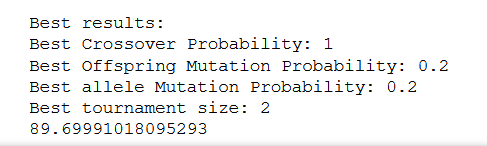

In [ ]:
# for blend cx

pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(10):
                    best_ind, best_score = blendcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

# Experimental runs

#### Fast code

In [5]:
pop_size = 100
NGEN = 30

t0 = time.time()

best_individuals = []
best_scores = []
for i in range(10):
    best_ind, best_score = twopointcx(1, 0.2, 0.1)
    best_individuals.append(best_ind)
    best_scores.append(best_score)
    
print(logbook)
print(best_scores)

t1 = time.time()

total = t1-t0
total

Gen 0: 
{'avg': array([-2.69017713]), 'std': array([6.41123183]), 'min': array([-7.59621264]), 'max': array([30.84670841])}
100
50
Gen : 1
{'avg': array([3.15070555]), 'std': array([9.18729102]), 'min': array([-4.7095302]), 'max': array([39.33011908])}
100
50
Gen : 2
{'avg': array([13.55402258]), 'std': array([15.00262015]), 'min': array([3.47057091]), 'max': array([66.67212383])}
100
50
Gen : 3
{'avg': array([22.04902851]), 'std': array([16.14981259]), 'min': array([4.29951963]), 'max': array([57.51936108])}
100
50
Gen : 4
{'avg': array([23.45799019]), 'std': array([13.99015053]), 'min': array([4.5456527]), 'max': array([57.46661051])}
100
50
Gen : 5
{'avg': array([30.90220174]), 'std': array([13.07646938]), 'min': array([12.9310958]), 'max': array([66.57065437])}
100
50
Gen : 6
{'avg': array([33.97098717]), 'std': array([11.55772825]), 'min': array([21.49061166]), 'max': array([75.62936197])}
100
50
Gen : 7
{'avg': array([28.434592]), 'std': array([14.64333583]), 'min': array([12.225

1415.8800919055939

In [7]:
np.mean(best_scores)

84.65659783149822

In [3]:
for indiv in best_individuals:
    #print(indiv)
    print(indiv.fitness.values)
    

(92.64317193830047,)
(93.07274631484279,)
(92.45873645484157,)


In [4]:
means = []
for indiv in best_individuals:
    fiveruns = []
    for i in range(5):
        fitness = toolbox.evaluate(np.array([indiv]))
        fiveruns.append(fitness)
    means.append(np.mean(fiveruns))
means
        
        
    


RUN: run status: enemy: 2; fitness: 92.64317193830047; player life: 82; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 92.53357331188757; player life: 82; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 92.64317193830047; player life: 82; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 91.85873645484158; player life: 74; enemy life: 0; time: 255

RUN: run status: enemy: 2; fitness: 92.50624979919323; player life: 76; enemy life: 0; time: 163

RUN: run status: enemy: 2; fitness: 93.07274631484279; player life: 80; enemy life: 0; time: 138

RUN: run status: enemy: 2; fitness: 93.07274631484279; player life: 80; enemy life: 0; time: 138

RUN: run status: enemy: 2; fitness: 93.07274631484279; player life: 80; enemy life: 0; time: 138

RUN: run status: enemy: 2; fitness: 92.50624979919323; player life: 76; enemy life: 0; time: 163

RUN: run status: en

[92.30747801963433, 92.84614770858298, 92.2955696132484]

{'whiskers': [<matplotlib.lines.Line2D at 0x194b25e9288>,
 'caps': [<matplotlib.lines.Line2D at 0x194b25e9d88>,
 'boxes': [<matplotlib.lines.Line2D at 0x194b25e4a88>],
 'medians': [<matplotlib.lines.Line2D at 0x194b25e9f08>],
 'fliers': [<matplotlib.lines.Line2D at 0x194b25f0dc8>],
 'means': []}

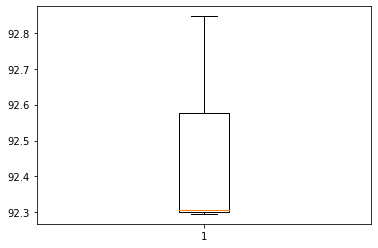

In [9]:
import matplotlib.pyplot as plt

plt.boxplot(means)

In [6]:
# create variables to later save the best individual
best_ind = 1
best_fit = -100
    

pop = toolbox.population(n=pop_size)
CXPB, MUTPB, NGEN = 0.7, 0.2, 10

# Evaluate the entire population
#fitnesses = map(toolbox.evaluate, np.array(pop))
#for ind, fit in zip(pop, fitnesses):
#    ind.fitness.values = fit
for i in range(pop_size):
    fitness = toolbox.evaluate(np.array([pop[i]]))
    pop[i].fitness.values = fitness
    if fitness > best_fit:
        best_fit = fitness
        best_ind = pop[i]
        
print(best_ind.fitness.values)


RUN: run status: enemy: 2; fitness: -5.796057750765372; player life: 0; enemy life: 100; time: 329

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 335

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 335

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: 88.38936470590374; player life: 34; enemy life: 0; time: 150

RUN: run status: enemy: 2; fitness: 57.216174817670264; player life: 0; enemy life: 30.0; time: 325

RUN: run status: enemy: 2; fitness: -5.8971538676367405; player life: 0; enemy life: 100; time: 364

RUN: run status: enemy: 2; fitness: 91.74250462797222; player life: 70; enemy life: 0; time: 192

RUN: run status: enemy: 2; fitness: -6.169610732491456; player life: 0; enemy life: 100; time: 478

R

In [7]:
import statistics

runs = 3
NGEN = 10
averages = []
standard_devs = []
standard_dev_up = []
standard_dev_min = []
maxima = []
y = 0
for i in range(NGEN):
    averages_of_generation = []
    maxima_of_generation = []
    x = y
    
    for j in range(runs):
        averages_of_generation.append(logbook[x]['avg'][0])
        maxima_of_generation.append(logbook[x]['max'][0])

        print(logbook[x]['avg'][0])
        x += 10
    averages.append(sum(averages_of_generation)/len(averages_of_generation))
    maxima.append(sum(maxima_of_generation)/len(maxima_of_generation))    
    standard_devs.append((statistics.stdev(averages_of_generation)))
    standard_dev_up.append(averages[-1]+standard_devs[-1])
    standard_dev_min.append(averages[-1]-standard_devs[-1])

    y+=1
print(averages)
print(maxima)
print(standard_devs)

gens = []
for i in range(NGEN):
    gens.append(i+1)
# print(logbook[30])

print(logbook[0]['avg'][0])

print(logbook)

print(logbook[0])



26.32577083069801
35.89439670529909
33.926338326307636
26.353613204929673
67.55106571014366
84.06222771564605
37.260535626543536
83.13974834978669
90.90239331924116
59.94015395638437
88.46962511731667
91.9031004920493
74.99077486353274
91.19068240411644
91.91025999984534
85.39997998261971
87.52931598415533
91.93282776167143
91.74100462406874
88.99897698058147
91.77410761680855
91.93843788227562
91.7674049694855
91.87046219009808
91.8266668533283
92.15281633766737
91.84260465907191
90.21583235770754
91.35839053717119
91.82530261018155
[32.04883528743491, 59.3223022102398, 70.43422576519046, 80.10429318858344, 86.03057242249817, 88.28737457614882, 90.83802974048626, 91.8587683472864, 91.94069595002253, 91.13317516835343]
[92.03385714498472, 91.55314521250433, 90.89103968869284, 92.12651676284759, 92.30157114383225, 92.50157114383227, 92.54983052167694, 92.36304963831856, 92.37010618735853, 92.36304963831856]
[5.053059818343095, 29.721296383900025, 28.990256161194388, 17.54683935980655, 9

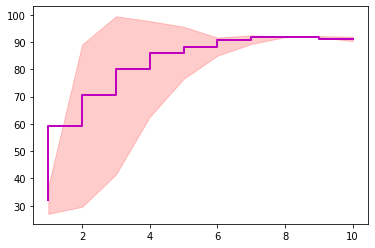

In [8]:
import matplotlib.pyplot as plt

f_5, axes_5 = plt.subplots()
# CB_lab_5 = r'Mean PR-curve CatBoost (AUC=%.2f  $\pm$ %0.2f)' % (CB_mean_auc_pr_5, CB_std_auc_pr_means_5)
CB_lab_5 = 'Mean '

# axes_5.step(average, CB_mean_precision_5, label=CB_lab_5, lw=2, color='m')
axes_5.step(gens, averages, label=CB_lab_5, lw=2, color='m')
# CB_tprs_upper_30 = [x+ for x in my_list]

# CB_tprs_upper_30 = np.minimum(CB_mean_tpr_30 + CB_std_tpr_30, 1)
# CB_tprs_lower_30 = np.maximum(CB_mean_tpr_30 - CB_std_tpr_30, 0)
axes_5.fill_between(gens, standard_dev_min, standard_dev_up, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

In [45]:
best_ind = 1
best_fit = -100


pop = toolbox.population(n=pop_size)
CXPB, MUTPB, NGEN = 0.7, 0.2, 10

# Evaluate the entire population
#fitnesses = map(toolbox.evaluate, np.array(pop))
#for ind, fit in zip(pop, fitnesses):
#    ind.fitness.values = fit
fitnesses = map(toolbox.evaluate, np.array(pop).reshape(1, len(pop), n_vars))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    if max(fit) > best_fit:
        best_fit = max(fit)
        best_ind = pop[np.where(fit == max(fit))[0][0]]


RUN: run status: enemy: 2; fitness: -5.771441123130016; player life: 0; enemy life: 100; time: 321

RUN: run status: enemy: 2; fitness: 21.10284613236326; player life: 0; enemy life: 70.0; time: 364

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: -5.814130531825066; player life: 0; enemy life: 100; time: 335

RUN: run status: enemy: 2; fitness: -5.783825182329737; player life: 0; enemy life: 100; time: 325

RUN: run status: enemy: 2; fitness: -5.327876168789581; player life: 0; enemy life: 100; time: 206

RUN: run status: enemy: 2; fitness: -5.393627546352362; player life: 0; enemy life: 100; time: 220

RUN: run status: enemy: 2; fitness: -5.676753802268282; player life: 0; enemy life: 100; time: 292

RUN: run status: enemy: 2; fitness: 39.216174817670264; player life: 0; enemy life: 50.0; time: 325